In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt


In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        print(f"Adding {self} and {other}")
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        print(f"Multiplying {self} and {other}")
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "supports int/float"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other*(self.data)**(other-1))*out.grad
        out._backward = _backward    
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(x: Value):
            if x not in visited:
                visited.add(x)
                for child in x._prev:
                    build_topo(child)
                topo.append(x)
        
        build_topo(self)
        for v in reversed(topo):
            v._backward()

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        vid = str(id(n))
        dot.node(name=vid, label = "{%s | grad %.4f | data %.4f}" % (n.label, n.grad,n.data), shape='record')
        if n._op:
            dot.node(name=vid+n._op, label=n._op)
            dot.edge(vid+n._op, vid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot


In [4]:
#x1 and x2 inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#w1 and #w2 inputs
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195433, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1+x2w2'
n = x1w1_x2w2 + b; n.label = 'n' 
#--------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#--------------
o.grad=1.0; o.label = 'o'
o.backward()


Multiplying Value(data=2.0) and Value(data=-3.0)
Multiplying Value(data=0.0) and Value(data=1.0)
Adding Value(data=-6.0) and Value(data=0.0)
Adding Value(data=-6.0) and Value(data=6.881373587019543)
Multiplying Value(data=0.8813735870195432) and Value(data=2)
Adding Value(data=5.828427124746192) and Value(data=-1)
Adding Value(data=5.828427124746192) and Value(data=1)
Multiplying Value(data=4.828427124746192) and Value(data=0.1464466094067262)


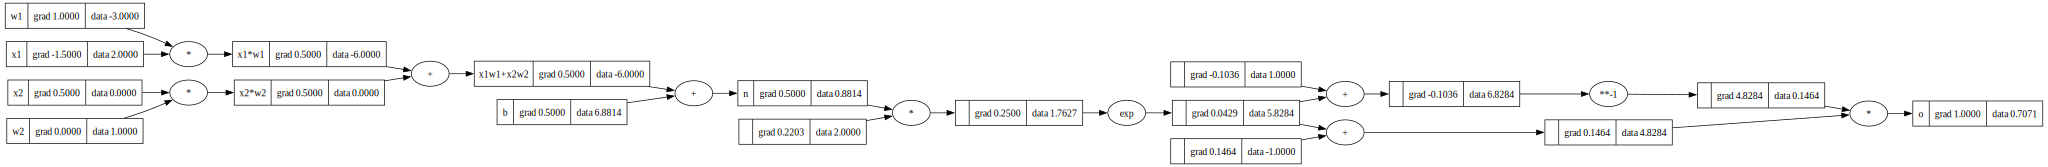

In [5]:
draw_dot(o)

In [6]:
import torch

In [7]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195433]); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
#----------
print(o.data.item())
o.backward()
#----------

0.7071066904050358


In [8]:
x1.grad.item()

-1.5000003851533106

In [ ]:
import random
import numpy as np
class Neuron:
    def __init__(self, nin: int):
        self.w = np.array([Value(random.uniform(-1,1)) for _ in range(nin)])
        self.b = Value(random.uniform(-1,1))
        # self.w = [Value(-3.0),Value(1.0)]
        # self.b = Value(6.8813735870195433)
    
    def __call__(self, x):
        act = sum((xi*wi for xi,wi in zip(x,self.w)), Value(0))+self.b
        o = act.tanh()
        return o

class Layer:
    def __init__(self, nin: int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

# class MLP:
#     def __init__(self, nin, nouts):
#         self.

In [26]:
t = Layer(2,3)
o = t([2.0,0.0])
print(o)

Multiplying Value(data=-3.0) and Value(data=2.0)
Adding Value(data=0) and Value(data=-6.0)
Multiplying Value(data=1.0) and Value(data=0.0)
Adding Value(data=-6.0) and Value(data=0.0)
Adding Value(data=-6.0) and Value(data=6.881373587019543)
Multiplying Value(data=-3.0) and Value(data=2.0)
Adding Value(data=0) and Value(data=-6.0)
Multiplying Value(data=1.0) and Value(data=0.0)
Adding Value(data=-6.0) and Value(data=0.0)
Adding Value(data=-6.0) and Value(data=6.881373587019543)
Multiplying Value(data=-3.0) and Value(data=2.0)
Adding Value(data=0) and Value(data=-6.0)
Multiplying Value(data=1.0) and Value(data=0.0)
Adding Value(data=-6.0) and Value(data=0.0)
Adding Value(data=-6.0) and Value(data=6.881373587019543)
[Value(data=0.7071067811865476), Value(data=0.7071067811865476), Value(data=0.7071067811865476)]


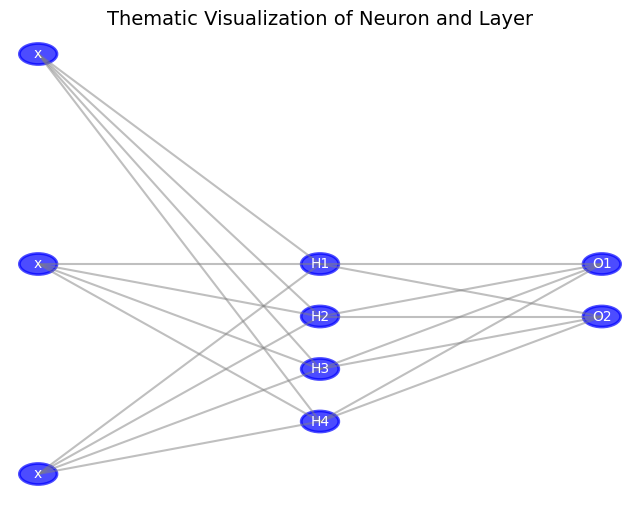

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_neuron(ax, x, y, size=0.2, label=None):
    """Draw a single neuron."""
    circle = plt.Circle((x, y), size, color='blue', alpha=0.7, lw=2)
    ax.add_artist(circle)
    if label:
        ax.text(x, y, label, color='white', fontsize=10, ha='center', va='center')

def plot_layer(ax, x, y, n_neurons, label_prefix="N", size=0.2, gap=1):
    """Draw a layer of neurons."""
    neurons = []
    for i in range(n_neurons):
        neuron_y = y - i * gap
        plot_neuron(ax, x, neuron_y, size=size, label=f"{label_prefix}{i+1}")
        neurons.append((x, neuron_y))
    return neurons

def plot_connections(ax, inputs, outputs):
    """Draw connections between two layers."""
    for x1, y1 in inputs:
        for x2, y2 in outputs:
            ax.plot([x1, x2], [y1, y2], 'gray', alpha=0.5)

def visualize_neuron_layer():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')

    # Input Layer
    inputs = [(0, y) for y in np.linspace(4, -4, 3)]
    for x, y in inputs:
        plot_neuron(ax, x, y, size=0.2, label=f"x")

    # Hidden Layer
    hidden = plot_layer(ax, 3, 0, n_neurons=4, label_prefix="H")

    # Output Layer
    output = plot_layer(ax, 6, 0, n_neurons=2, label_prefix="O")

    # Connections
    plot_connections(ax, inputs, hidden)
    plot_connections(ax, hidden, output)

    plt.title("Thematic Visualization of Neuron and Layer", fontsize=14)
    plt.show()

# Run the visualization
visualize_neuron_layer()
